In [1]:
import numpy as np
import pandas as pd 
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

In [2]:
directories = {
    'image': r'C:\Users\GOOGLES\Xray\image',
    'xray': r'C:\Users\GOOGLES\Xray\xray',

}

# Load and shuffle image paths and labels
image_paths = []
labels = []
for category, directory_path in directories.items():
    image_files = [file for file in os.listdir(directory_path) if file.lower().endswith(('.jpg', '.jpeg'))]
    image_paths.extend([os.path.join(directory_path, file) for file in image_files])
    labels.extend([category] * len(image_files))

In [3]:
indices = np.arange(len(image_paths))
np.random.shuffle(indices)

shuffled_image_paths = []
shuffled_labels = []

for index in indices:
    try:
        image_path = image_paths[index]
        label = labels[index]

        image = Image.open(image_path)
        image = image.resize((224, 224), Image.BILINEAR)

        image_array = np.array(image)

        shuffled_image_paths.append(image_array)
        shuffled_labels.append(label)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

X_shuffled = np.array(shuffled_image_paths)
Y_shuffled = np.array(shuffled_labels)

Error processing image C:\Users\GOOGLES\Xray\xray\img-00088-00001 (4th copy).jpg: image file is truncated (34 bytes not processed)


In [4]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X_shuffled, Y_shuffled, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [5]:
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)
Y_test_encoded = label_encoder.transform(Y_test)

In [6]:
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [9]:
history = model.fit(
    image_generator.flow(X_train, Y_train_encoded, batch_size=32),
    validation_data=image_generator.flow(X_val, Y_val_encoded),
    epochs=5,
)

Epoch 1/5


9/9 [==============================] - 10s 905ms/step - loss: 0.3499 - accuracy: 0.8375 - val_loss: 0.1171 - val_accuracy: 1.0000
Epoch 2/5
9/9 [==============================] - 7s 776ms/step - loss: 0.0794 - accuracy: 0.9928 - val_loss: 0.0229 - val_accuracy: 1.0000
Epoch 3/5
9/9 [==============================] - 7s 804ms/step - loss: 0.0156 - accuracy: 0.9964 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 4/5
9/9 [==============================] - 7s 787ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 5/5
9/9 [==============================] - 7s 771ms/step - loss: 9.6692e-04 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000


In [26]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2/2 [==============================] - 1s 64ms/step - loss: 0.0013 - accuracy: 1.0000
Test Accuracy: 100.00%


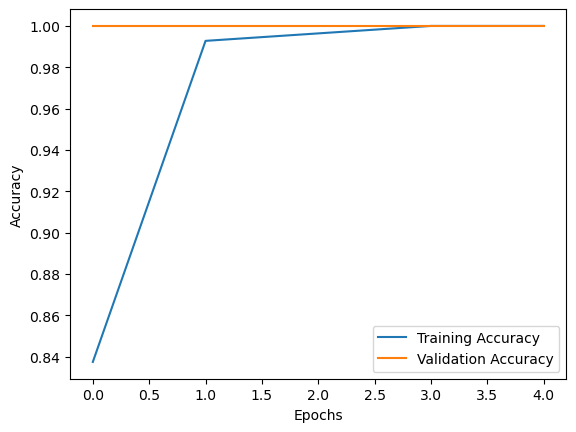

In [11]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

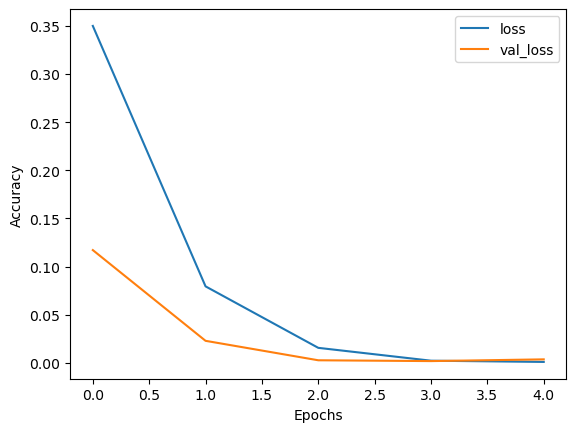

In [12]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

2/2 [==============================] - 1s 56ms/step


In [14]:
Y_test_original = label_encoder.inverse_transform(Y_test_encoded)
Y_pred_original = label_encoder.inverse_transform(y_pred_classes)

In [15]:
from sklearn.metrics import classification_report
report = classification_report(Y_test_original, Y_pred_original)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       image       1.00      1.00      1.00         2
        xray       1.00      1.00      1.00        33

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35



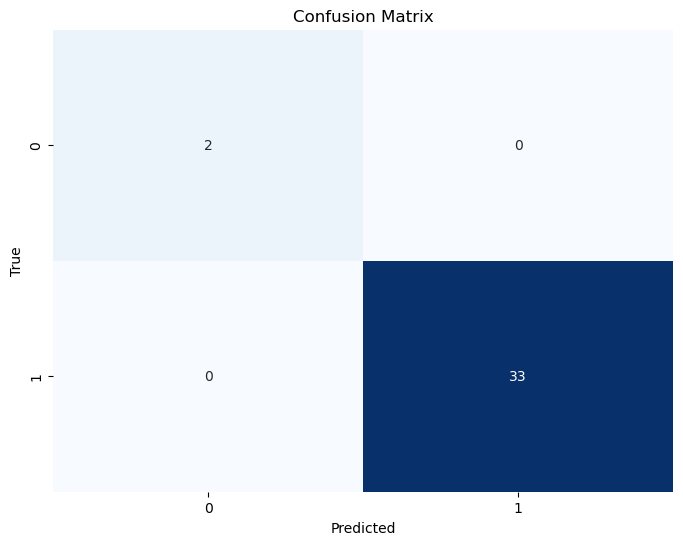

In [16]:
from sklearn.metrics import  confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion = confusion_matrix(Y_test_original, Y_pred_original)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

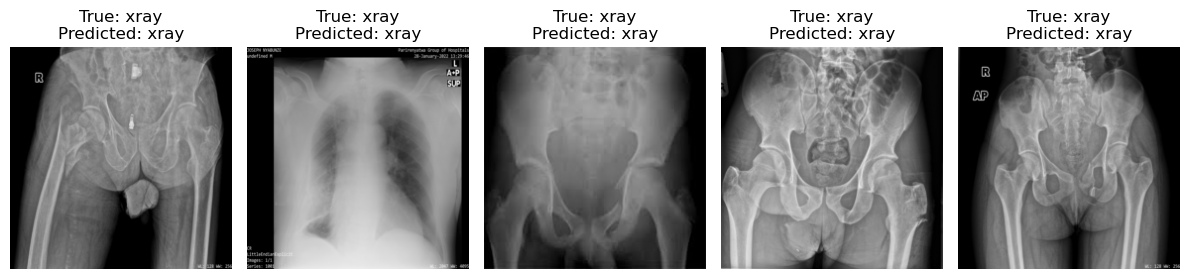

In [17]:
num_images_to_display = 5  
plt.figure(figsize=(12, 8))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(X_test[i])
    plt.title(f'True: {Y_test_original[i]}\nPredicted: {Y_pred_original[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [18]:
1

1

In [23]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

# Load the image you want to predict
image_path = "5.jpg"  # Replace with the actual path to your image
img = image.load_img(image_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand the dimensions to match the input shape expected by the model
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Decode the predictions (assuming your labels are "image" and "xray")
decoded_predictions = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

print("Predicted class:", decoded_predictions[0])


1/1 [==============================] - 0s 31ms/step
Predicted class: xray


In [24]:
model_filename = "NotX.h5"
model.save(model_filename)

print(f"Model saved as {model_filename}")

C:\Users\GOOGLES\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as NotX.h5


In [25]:
model = tf.keras.models.load_model("NotX.h5")
